In [1]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict
#from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
#from typing import TypedDict
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool



In [3]:
#os.environ['LANGSMITH_API_KEY'] = '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'
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
#os.environ["LANGCHAIN_PROJECT"] = "pr-abandoned-whelp-89"
#os.environ["OPENAI_API_KEY"] = 'sk-JWjifjj0kI3BV4HdndK50kIVp2lnsxu_Q3pxT6-gRaT3BlbkFJYw8PYg0rV4VzSFOCRhTHlQaXzcax7VSJjfFX5t960A'
#os.environ["SERPER_API_KEY"] = '5f41c081de76c36d99628c8f99ce10f26595258a'


In [4]:
llm = ChatOpenAI()
llm.invoke("Hello, world!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BlEeWTMSlHIUB2oYHVqYSoYNEM0Py', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6b499598-dd8b-4a7f-8a05-e4e4a44ca6cb-0', usage_metadata={'input_tokens': 11, 'output_tokens': 9, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")

"Paris is the capital and largest city of France. With an estimated population of 2,048,472 residents in January 2025 in an area of more than 105 km2 (41 sq ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world's most important and ... The capital of France has been Paris since its liberation in 1944. Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris became capital of France because France evolved from a federation of counties to a kingdom, where the king was living a Paris. NARRATOR

In [6]:
tool_search =Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need more information from an online search"
    )

In [7]:
tool_search.invoke("What is the capital of France?")

"Paris is the capital and largest city of France. With an estimated population of 2,048,472 residents in January 2025 in an area of more than 105 km2 (41 sq ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world's most important and ... The capital of France has been Paris since its liberation in 1944. Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... NARRATOR: The Eiffel Tower is the best-known symbol of Paris, the capital of France. Paris is an important center for business and culture. W

In [8]:
#os.environ['PUSHOVER_TOKEN'] = 'a88tn2eyvrhvcga3zf7wghvco6d8hp'
#os.environ['PUSHOVER_USER'] = 'ue8kfjibkvpsnk2m2wjjiskgoaqqcb'
#os.environ['PUSHOVER_URL'] = 'https://api.pushover.net/1/messages.json'


In [9]:
#pushover_token = os.getenv("PUSHOVER_TOKEN")
#pushover_user = os.getenv("PUSHOVER_USER")
#pushover_url = "https://api.pushover.net/1/messages.json"

In [10]:
def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [11]:
tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

In [12]:
tool_push.invoke("Hello, me")

In [13]:
tools = [tool_search, tool_push]

In [14]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [15]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [16]:
# This is different:

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [17]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [18]:
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

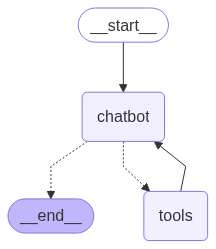

In [19]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\krish\miniconda3\Lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\krish\miniconda3\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\krish\miniconda3\Lib\site-packages\gradio\blocks.py", line 2193, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\krish\miniconda3\Lib\site-packages\gradio\blocks.py", line 1702, in call_function
    prediction = await fn(*processed_input)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\krish\miniconda3\Lib\site-packages\gradio\utils.py", line 861, in async_wrapper
    response = await f(*args, **kwargs)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kr

In [21]:
from langgraph.checkpoint.memory import MemorySaver

In [22]:
memory = MemorySaver()

In [23]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [24]:
def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [25]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

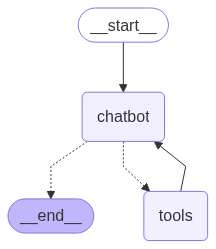

In [26]:
# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
config = {"configurable": {"thread_id": "1"}}

In [28]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content

In [29]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [30]:
graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [31]:
list(graph.get_state_history(config))

[]

{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='8310ea4b-8b43-4a29-a681-67616a98f622')]}
{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='8310ea4b-8b43-4a29-a681-67616a98f622'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 90, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BlEf0wib3zxug6xkFbEow5QbZk3Cq', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ac12c4bd-22fe-47a6-8375-5ec950020c55-0', usage_metadata={'input_tokens': 90, 'output_tokens': 10, 'total_tokens': 100, 'i